# Southern Ocean temperature profile classifier

This code classifies Southern Ocean (south of roughly 30°S) temperature profiles using the GMM model discussed in this work: https://eartharxiv.org/m64t7

Given a set of temperature values on the pressure levels indicated in the file "Depth_retained.csv", the code in this notebook assigns class labels based on an eight-class GMM statistical model, the parameters of which have been fit using a subset of SO temperature profiles as deescribed in the preprint linked above. This notebook also returns posterior probabilities for each class and profile.

Input: temperature values on pressure levels indicated in the file "Depth_retained.csv"

Output: table of classes and maximum posterior probabilities and a selected temperature profile plot

## Import modules

In [1]:
from sklearn import mixture
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

## Load data

In [2]:
# load object for standardizing profiles by vertical level
scale = pickle.load( open( "Scale_object.pkl", "rb" ) )
# load object for dimension reduction using PCA
pca = pickle.load( open( "PCA_object.pkl", "rb" ) )
# load object for GMM classification
gmm = pickle.load( open( "GMM_object.pkl", "rb" ) )

# get pressure levels on which temperature is defined
pressures = pd.read_csv("Depth_retained.csv")

# get sample profiles from CSV
dfSample = pd.read_csv("sample_profiles.csv")

## Transform data using standardization, PCA, then apply GMM

Below, we use the "scale", "pca", and "gmm" objects to transform and classify the data. To create a new statistical model, use the "fit" methods associated with the scaler, pca, and gmm objects [e.g. gmm.fit(X)]. For example code, see the source code in this repository.  

GMM returns class labels that are unsorted. The dictionary below maps unsorted class labels to class labels that have been sorted by the mean temperature of all profiles in that class in the training dataset. 

In [3]:
# map from unsorted to sorted properties
# based on class mean temperatures
mapping = {
    1 : 1,
    3 : 2,
    6 : 3,
    7 : 4,
    4 : 5,
    2 : 6,
    0 : 7,
    5 : 8,
}

# standardize data
X = dfSample.values[:,1:].T
Xscaled = scale.transform(X)
# dimension reduction via PCA
Xpca = pca.transform(Xscaled)
# assign labels to each profile based on GMM classes
labels_unsorted = gmm.predict(Xpca)
# get posterior probabilities
posteriors = gmm.predict_proba(Xpca)
# class label is based on maximum posterior prob.
ppmax = np.max(posteriors,axis=1)

# sort labels based on class mean temperature properties
labels_sorted = np.empty(labels_unsorted.size, dtype=int)
for key, val in mapping.items():
    labels_sorted[labels_unsorted == key] = val

## Display results as a table

In [4]:
# display results (python indexing starts from 0)
ls1 = pd.Series(labels_sorted)
ps1 = pd.Series(ppmax)
dfRes = pd.concat([ls1, ps1], axis=1)
dfRes.rename(columns={0:"Class", 1:"Max. post. prob."})

,Class,Max. post. prob.
0,3,0.997914
1,7,0.994708
2,8,0.702473
3,1,0.775394
4,5,0.930772
5,4,0.556371
6,6,0.999997


The first column is an index that starts from zero (python indexing convention). It corresponds to "iplot" in the sample plotting code below. The second column is the class label assigned by GMM, sorted by mean class temperature from the training dataset. The third column is the posterior probability, which ranges from 0 to 1. 

## Plot sample profiles

Here we plot a single profile for visualisation purposes, along with its assigned class and posterior probability. Note that individual profiles may or may not resemble the mean profile of that class, as there is variability of profile structure within the classes.

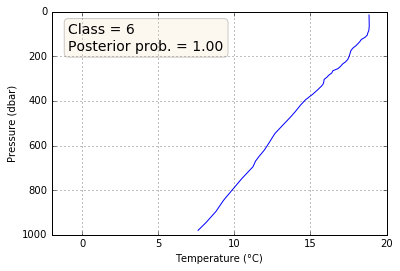

In [5]:
# plot example temperature profile
iplot = 6
iclass = labels_sorted[iplot]
ipost = ppmax[iplot]
plt.plot(X[iplot,:],pressures.values)

# custom grid and axes
ax = plt.gca()
ax.invert_yaxis() 
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.xlim([-2, 20])
ax.grid(True)

# text box
textstr = '\n'.join((
    r'Class = %i' % (iclass, ),
    r'Posterior prob. = %.2f' % (ipost, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# show plot
plt.show()

This particular profile (iplot=6) features a mixed layer of roughly uniform temperature in the top ~100m and a somewhat monotonic decrease in temperature with increasing pressure. It belongs to one of the warmer, subtropical classes (class 6). 

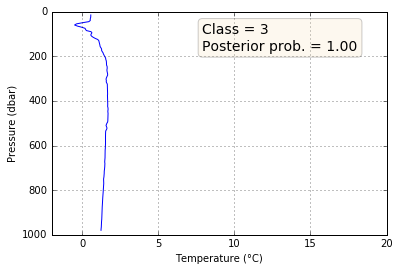

In [6]:
# plot example temperature profile
iplot = 0
iclass = labels_sorted[iplot]
ipost = ppmax[iplot]
plt.plot(X[iplot,:],pressures.values)

# custom grid and axes
ax = plt.gca()
ax.invert_yaxis() 
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.xlim([-2, 20])
ax.grid(True)

# text box
textstr = '\n'.join((
    r'Class = %i' % (iclass, ),
    r'Posterior prob. = %.2f' % (ipost, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
# place a text box in upper left in axes coords
ax.text(0.45, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# show plot
plt.show()

This profile (iprof=0) has been assigned to one of the relatively cool circumpolar classes (class 3) located roughly south of the Subantarctic Front. It features a temperature inversion (cooler near the surface, with a warmer layer in the interior) and roughly monotonic cooling below ~400 m.

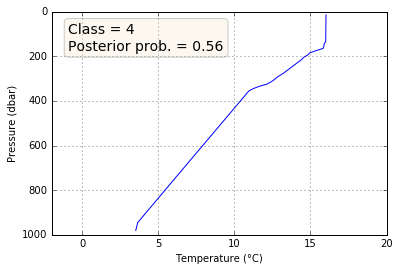

In [7]:
# plot example temperature profile
iplot = 5
iclass = labels_sorted[iplot]
ipost = ppmax[iplot]
plt.plot(X[iplot,:],pressures.values)

# custom grid and axes
ax = plt.gca()
ax.invert_yaxis() 
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.xlim([-2, 20])
ax.grid(True)

# text box
textstr = '\n'.join((
    r'Class = %i' % (iclass, ),
    r'Posterior prob. = %.2f' % (ipost, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# show plot
plt.show()

This sample profile (iplot=5) was difficult for GMM to classify, as shown by the low posterior probability (0.56). It features a mixed layer of uniform temperature and decreaasing temperatures with increasing pressure. The rate of change of temperature with pressure appears to decrease sharply around ~350 m or so.